In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [2]:
train_path = './data/train'
valid_path = './data/test'
train_image_files = glob(train_path +'/*/*.jpg')
valid_image_files = glob(valid_path +'/*/*.jpg')

In [3]:
folders = glob(train_path + '/*')
print(folders)

['./data/train\\0', './data/train\\1', './data/train\\2', './data/train\\3', './data/train\\4', './data/train\\5']


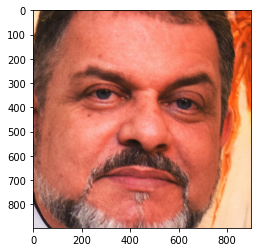

In [4]:
plt.imshow(image.load_img(np.random.choice(valid_image_files)))
plt.show()

In [5]:
#Set image size because the image are too large
IMAGE_SIZE = [200,200]
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE+[3],
    weights='imagenet',
    include_top=False)

ptm.trainable = False

In [6]:
#map the data into features vectors
K = len(folders) #number of classes
x = AveragePooling2D()(ptm.output)
x = Flatten()(x)
#x = Dense(K,activation='softmax')(x)

model = Model(inputs=ptm.input, outputs=x)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [7]:
gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [8]:
emo_dict = {0: 'happy', 1: 'sad',
                     2: 'surprise', 3: 'fear',
                     4: 'disgust-contempt', 5: 'anger'}

emotions = list(emo_dict.keys())

batch_size = 128
#create generators
train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode = 'sparse'
)

valid_generator = gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode = 'sparse'
)

Found 39864 images belonging to 6 classes.
Found 4983 images belonging to 6 classes.


In [19]:
N_train = len(train_image_files)
N_valid = len(valid_image_files)

#figure output size
feat = model.predict(np.random.random([1]+IMAGE_SIZE+[3]))
D = feat.shape[1]

X_train = np.zeros((N_train,D))
Y_train = np.zeros(N_train)
X_valid = np.zeros((N_valid,D))
Y_valid = np.zeros(N_valid)

In [20]:
i = 0
for x, y in train_generator:
    D = model.predict(x)
     #get features
    features = model.predict(x)
  
    #size of the batch (not always is the size of the batch)
    sz = len(y) #nuber of samples on this batch
    X_train[i:i+sz]=features
    Y_train[i:i+sz]=y

    i += sz
    if i%1280==0:
        print(i)

    if i>=N_train:
        print('breaking now')
        break

print(i)

1280
2560
3840
5120
6400
7680
8960
10240
11520
12800
14080
15360
16640
17920
19200
20480
21760
23040
24320
25600
26880
28160
29440
30720
32000
33280
34560
35840
37120
38400
39680
breaking now
39864


In [21]:
np.save('X_train_ResNet50.npy', X_train)
np.save('Y_train_ResNet50.npy', Y_train)

In [22]:
i = 0
for x, y in valid_generator:
    D = model.predict(x)
     #get features
    features = model.predict(x)
  
    #size of the batch (not always is the size of the batch)
    sz = len(y) #nuber of samples on this batch
    X_valid[i:i+sz]=features
    Y_valid[i:i+sz]=y

    i += sz
    if i%1280==0:
        print(i)

    if i>=N_valid:
        print('breaking now')
        break

print(i)

1280
2560
3840
breaking now
4983


In [23]:
np.save('X_valid_ResNet50.npy', X_valid)
np.save('Y_valid_ResNet50.npy', Y_valid)

In [9]:
X_train = np.load('X_train_ResNet50.npy')
Y_train = np.load('Y_train_ResNet50.npy')
X_valid = np.load('X_valid_ResNet50.npy')
Y_valid = np.load('Y_valid_ResNet50.npy')

In [10]:
from tensorflow.keras.layers import Dropout

feat = model.predict(np.random.random([1]+IMAGE_SIZE+[3]))
D = feat.shape[1]

#Modelo de red neuronal para clasificación binaria
i = Input(shape=(D,))
#x = Dense(1000, activation='relu')(i)
x = Dense(4096, activation='relu')(i)
x = Dropout(0.2)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(6, activation='softmax')(x)

emo_model = Model(i ,x)

emo_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics='accuracy'
)

In [11]:
r = emo_model.fit(
    X_train, Y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_valid,Y_valid)
)

Epoch 1/10
312/312 [==============================] - 242s 776ms/step - loss: 2.2053 - accuracy: 0.3812 - val_loss: 1.3263 - val_accuracy: 0.4598
Epoch 2/10
312/312 [==============================] - 243s 777ms/step - loss: 1.3014 - accuracy: 0.4752 - val_loss: 1.2825 - val_accuracy: 0.5013
Epoch 3/10
312/312 [==============================] - 247s 791ms/step - loss: 1.2125 - accuracy: 0.5175 - val_loss: 1.2221 - val_accuracy: 0.5133
Epoch 4/10
312/312 [==============================] - 243s 779ms/step - loss: 1.1275 - accuracy: 0.5547 - val_loss: 1.2321 - val_accuracy: 0.5188
Epoch 5/10
312/312 [==============================] - 242s 776ms/step - loss: 1.0576 - accuracy: 0.5812 - val_loss: 1.2487 - val_accuracy: 0.5127
Epoch 6/10
312/312 [==============================] - 245s 786ms/step - loss: 1.0067 - accuracy: 0.6022 - val_loss: 1.2433 - val_accuracy: 0.5152
Epoch 7/10
312/312 [==============================] - 245s 786ms/step - loss: 0.9516 - accuracy: 0.6248 - val_loss: 1.2424 -

In [12]:
p = emo_model.predict(X_valid)
pred = np.argmax(p, axis=1)

In [13]:
Y_valid = Y_valid.astype(int)

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

#Definición para el calculo de metricas multi-clase
def calculo_metricas(CM, emociones):
    
    emocion = []
    TruPos = []
    FalPos = []
    FalNeg = []
    TruNeg = []
    acc = []
    prec = []
    recall = []
    f1 = []
    
    total = np.sum(CM)
    
    for i in range(len(emociones)):
       
        TP = CM[i][i]
        FP = sum(CM[:,i])-TP
        FN = sum(CM[i,:])-TP
        TN = total - TP-FN-FP
        a = (TP+TN)/(TP+TN+FN+FP)
        p = TP/(TP+FP)
        r = TP/(TP+FN)
        f = 2*(r*p)/(r+p)
        
        emocion.append(emociones[i])
        TruPos.append(TP)
        FalPos.append(FP)
        TruNeg.append(TN)
        acc.append(a)
        prec.append(p)
        recall.append(r)
        f1.append(f)
    
    metricas = pd.DataFrame()
    metricas['Emociones']=emocion
    metricas['Accuracy']=acc
    metricas['Precision']=prec
    metricas['Recall']=recall
    metricas['F1-Score']=f1
    
    return metricas

def graf_confusion_matrix(CM, emociones,emb):
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(CM,annot=True,fmt='',xticklabels=emociones,yticklabels=emociones, ax=ax, cmap='Blues');
    ax.set_title('Matriz de confusión '+emb);
    ax.set_xlabel('Valores Predecidos');
    ax.set_ylabel('Valores Verdaderos');
    
def graficar_historia_entrenamiento(log):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(log.history['loss'], label='train')
    ax1.plot(log.history['val_loss'], label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log.history['accuracy'], label='train')
    ax2.plot(log.history['val_accuracy'], label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    #ax2.set_ylim((0.0, 1.0))
    #for ax in axes: ax.legend()

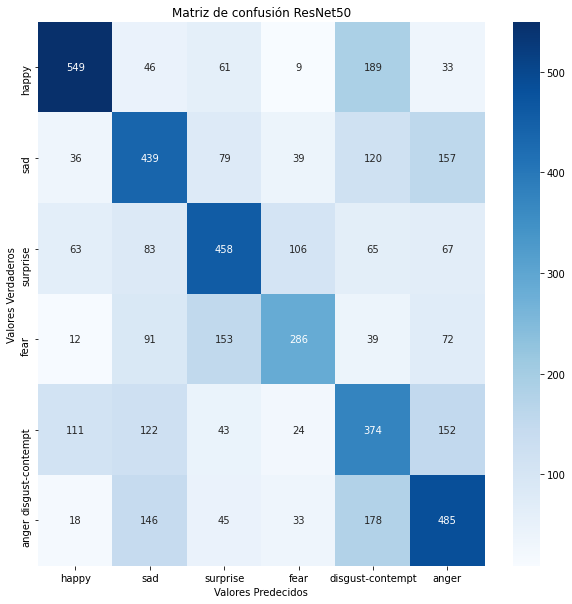

In [15]:
emo_dict = {0: 'happy', 1: 'sad', 2: 'surprise', 3: 'fear', 4: 'disgust-contempt', 5: 'anger'}
emociones_1 = list(emo_dict.values())

CM_ResNet = confusion_matrix(Y_valid, pred)
graf_confusion_matrix(CM_ResNet, emociones_1 ,'ResNet50')

In [16]:
m1 = calculo_metricas(CM_ResNet, emociones_1)
m1

,Emociones,Accuracy,Precision,Recall,F1-Score
0,happy,0.884006,0.695817,0.618940,0.655131
1,sad,0.815573,0.473571,0.504598,0.488592
2,surprise,0.846478,0.545888,0.543943,0.544914
3,fear,0.884006,0.575453,0.437979,0.497391
4,disgust-contempt,0.790688,0.387565,0.452785,0.417644
5,anger,0.819185,0.502070,0.535912,0.518439


In [17]:
emo_model.save('top_ResNet50_emotions_v1.h5')